# 学習済みのVGGモデルの使用
VGGモデルを使用して画像分類の転移学習を行う  
1. PyTorchでImageNetのモデルをロード
2. VGGの理解
3. 入力画像の前処理
  
ほぼ[これ](http://aidiary.hatenablog.com/entry/20180212/1518404395)

## ImageNetデータセットとVGG-16モデル
ImageNetデータセット: スタンフォード大学の大規模Annotated画像データセット  
- クラス数: 1000種類
- 学習用データ: 120万枚
- 検証用データ: 5万枚
- テスト用データ: 10万枚
PyTorchから使用可能

VGG-16モデル: 畳み込み層または全結合層を16層使用した画像認識モデル

## データセットの用意

In [1]:
import os
import urllib.request
import zipfile

In [2]:
data_dir = "../../datasets/ptca_datasets/chapter1"
image_net_path = os.path.join(data_dir, "imagenet_class_index.json")
hymenoptera_path = os.path.join(data_dir, "hymenoptera_data.zip")

In [3]:
# データセットのフォルダが存在しない場合は作成
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    
# ImageNetのclass_indexを,なければダウンロード
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
if not os.path.exists(image_net_path):
    urllib.request.urlretrieve(url, image_net_path)

# 1.3節で使用するアリとハチの画像データをなければダウンロードし解凍
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
if not os.path.exists(hymenoptera_path):
    urllib.request.urlretrieve(url, hymenoptera_path)

    zip = zipfile.ZipFile(hymenoptera_path) # ZIPファイル読み込み
    zip.extractall(data_dir) # 解凍
    zip.close()

    os.remove(hymenoptera_path) # ZIPファイル消去

[ゴールデンリトリバーの画像](https://pixabay.com/ja/photos/goldenretriever-%E7%8A%AC-3724972/)(640×426)を手動でダウンロード  
data_dir直下に配置．  masterにもある

## パッケージのimportとTorchのバージョン確認

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch, torchvision, json
from torchvision import models, transforms
%matplotlib inline

print("PyTorch Version:", torch.__version__)
print("TorchVision Version:", torchvision.__version__)

PyTorch Version: 1.2.0
TorchVision Version: 0.4.0


## VGG-16学習済みモデルのロード

In [3]:
# 学習済みモデルは~/.cache/torch/checkpoints/vgg16-hogehoge.pthへ行く
net = models.vgg16(pretrained=True)
net.eval() # 推論モードに設定, not 学習モード
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

featuresとclassifierという2つのモジュールがある  
ReLU, プーリング層, Dropoutを含めない全結合層と畳み込み層が合計で16層  

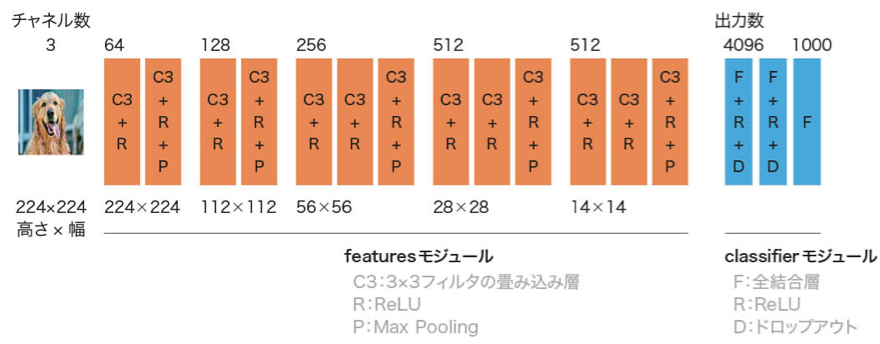

## 入力画像の前処理クラスを作成
- 画像を(224, 224)へリサイズ
- 色の規格化(明度を考慮)

In [9]:
class BaseTransform():
    """
    画像のリサイズと規格化を行う
    
    Attributes
    -------------
    resize: int
        リサイズ先の画像の大きさ
    mean: (R, G, B)
        各色チャネルの平均値
    std: (R, G, B)
        各色チャネルの標準偏差
    """
    
    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),              # 短辺の長さをresizeにする
            transforms.CenterCrop(resize),     # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),                  # TorchTensorに変換
            transforms.Normalize(mean, std) # 色情報の標準化
        ])
    
    def __call__(self, img):
        return self.base_transform(img)

画像処理の動作を確認する  
ゴールデンレトリバーの画像を処理してみる

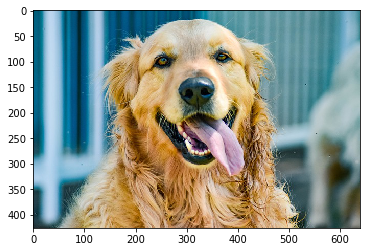

In [14]:
image_file_path = os.path.join(data_dir, "goldenretriever-3724972_640.jpg")
img = Image.open(image_file_path)

plt.imshow(img)

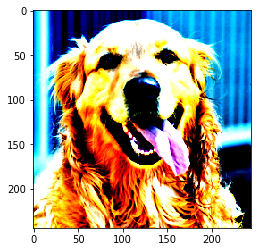

In [15]:
resize = 244
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img) # TorchTensor (3, 224, 224)

img = img_transformed.numpy().transpose((1, 2, 0)) # (H, W, C)
img = np.clip(img, 0, 1)
plt.imshow(img)

## 出力からラベルを予測する後処理クラスを作成
VGG-16モデルの1000次元の出力を ラベル名に変換  
VGG-16 -> torch -> np.arr -> argmax -> id  
imagenet_class_index.jsonにidに対応するラベルの情報が入っている  

In [17]:
ILSVRC_class_index = json.load(open(os.path.join(data_dir, "imagenet_class_index.json"), 'r'))

In [18]:
class ILSVRCPredictior():
    """
    モデルの出力からラベル名を求める
    """
    
    def __init__(self, class_index):
        self.class_index = class_index
    
    def predict_max(self, out):
        """
        確率最大のILSVRCのラベル名を取得
        
        Parameters
        --------------
        out: torch.Size([1, 1000])
            Netからの出力
        
        Returns
        ---------
        predicted_label_name: str
            最も予測確率が高いラベルの名前
        """
        
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]
        
        return predicted_label_name

## 学習済みVGGモデルで手元の画像を予測
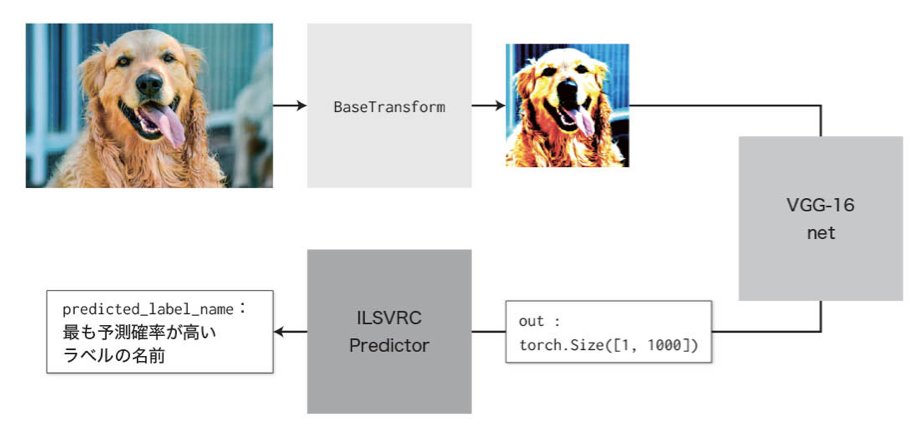

In [19]:
predictor = ILSVRCPredictior(ILSVRC_class_index)

# (1, 3, 224, 224)に次元を増やす
# 元はバッチ処理できるようになっているため
# _によってin-place処理，すなわち元のテンソルの内容を書き換える
inputs = img_transformed.unsqueeze_(0) 

out = net(inputs)
result = predictor.predict_max(out)

print("入力画像の予測結果: ", result)

入力画像の予測結果:  golden_retriever


# PyTorchによるDL実装の流れ
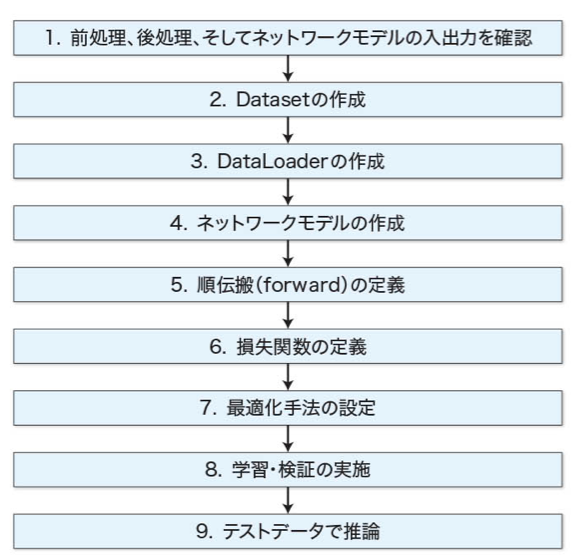

Dataset: 入力データとラベルなどのペアを保持するクラス  
DataLoader: Datasetからミニバッチを作成 など  
ネットワークの途中分岐など複雑な順伝播は手作業で定義する必要がある  
損失関数も，複雑ならば自分で定義する必要がある  